In [74]:
import numpy as np
import sys
import os

sys.path.append("/home/haricash/anaconda3/envs/cosmo-trc/lib/python3.9/site-packages/")

import emcee

In [75]:
temp_data = np.loadtxt("milankovitch.dat")
age = temp_data[:,2]
T = temp_data[:,4]

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

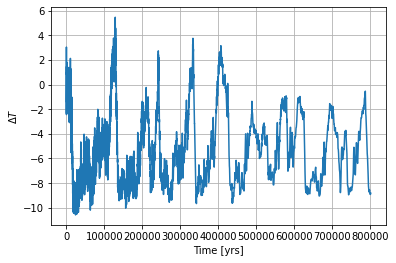

In [77]:
fig, ax = plt.subplots()
ax.plot(age, T)
ax.set_xlabel("Time [yrs]")
ax.set_ylabel("$\Delta T$")
plt.grid()

In [87]:
def model(theta, age=age):
    a1, a2, a3, p1, p2, p3, T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

In [88]:
def ln_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum((y-model(theta, age)/yerr) ** 2)    

In [89]:
def ln_prior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    else :
        return -np.inf

In [90]:
def ln_prob(theta, x, y, yerr):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + ln_likelihood(theta, x, y, yerr)

In [91]:
# Some important variables

Terr = 0.05*np.average(T) # we manually construct the errors i.e. yerr values
data = (age, T, Terr) # a data holder for our x,y,yerr
nwalkers = 32 # number of walkers
niter = 500 # number of iterations for the what?
initial = np.array([1.0, 1.0, 1.0, 26000., 41000., 100000., -4.5]) # this is the initial guess for our theta
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)] # this is how we move from one 
# location to another - how to sample for each step

In [92]:
def main(p0,nwalkers,niter,ndim,ln_prob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    
    print("Run Complete!")

    return sampler, pos, prob, state

In [93]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_prob,data)

Running burn-in...
Running production...
Run Complete!


In [94]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

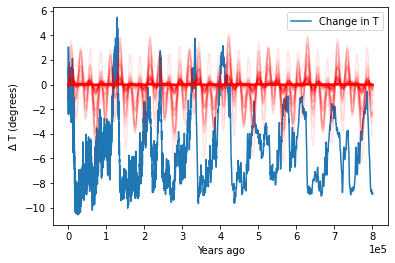

In [95]:
plotter(sampler)

In [96]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 3.30300211e-02,  6.81769007e-03,  1.98837947e-04,  2.64043745e+04,
        4.14151078e+04,  1.00177675e+05, -2.62188895e-05])

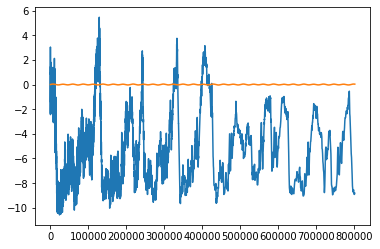

Theta max: [ 3.30300211e-02  6.81769007e-03  1.98837947e-04  2.64043745e+04
  4.14151078e+04  1.00177675e+05 -2.62188895e-05]


In [97]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()
print("Theta max:" ,theta_max)

In [99]:
import corner

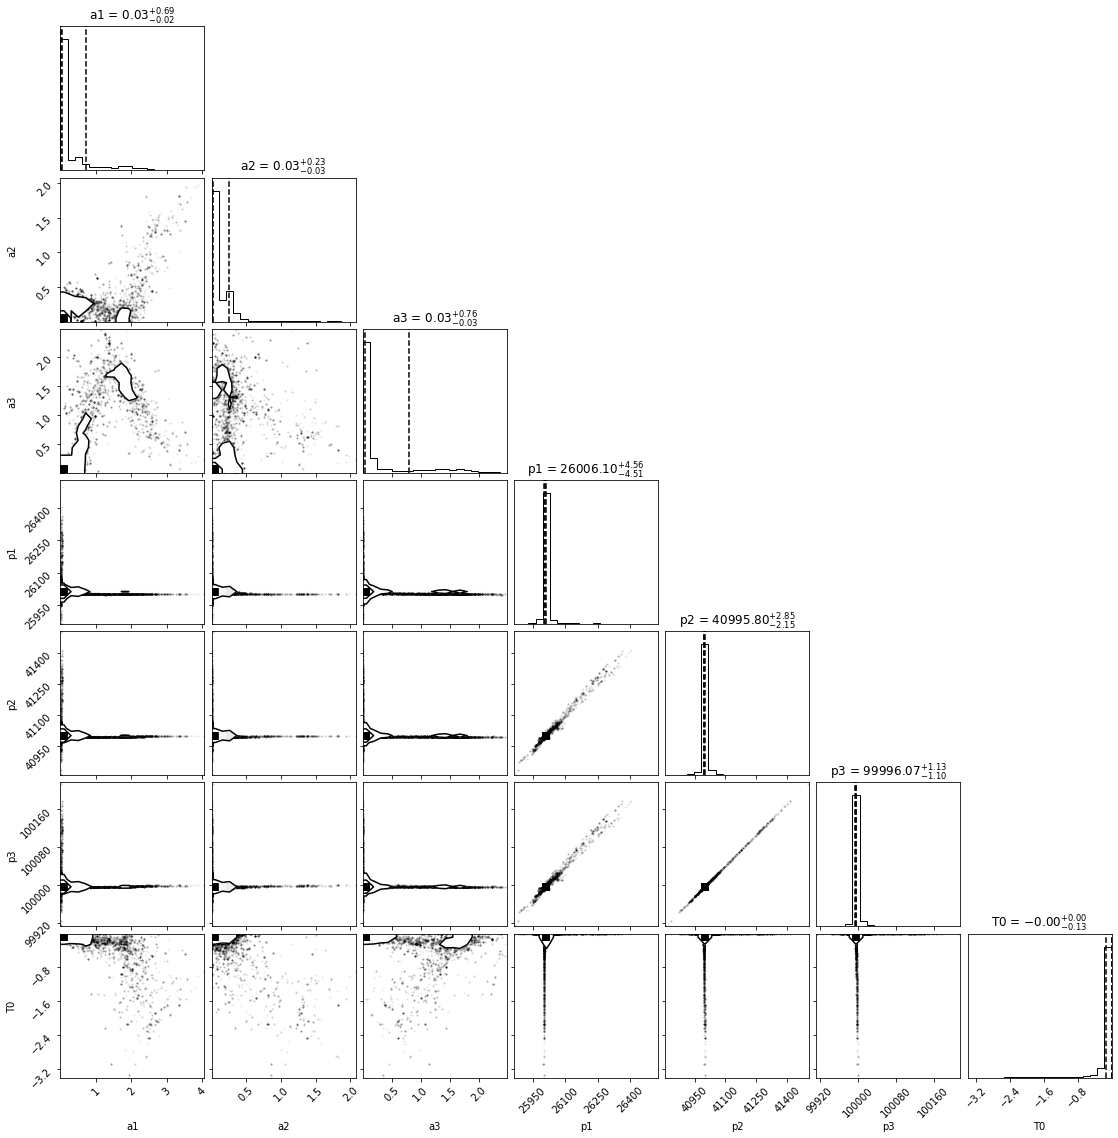

In [100]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [101]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240
niter = 1024
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,ln_prob,data)

Running burn-in...
Running production...
Run Complete!


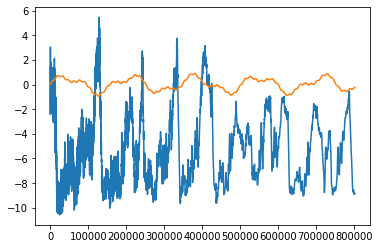

Theta max:  [ 6.96016373e-02  2.97399902e-01  5.81796758e-01  1.45296052e+04
  7.12794818e+04  1.68750933e+05 -5.78527357e-05]


In [103]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print("Theta max: ",new_theta_max)

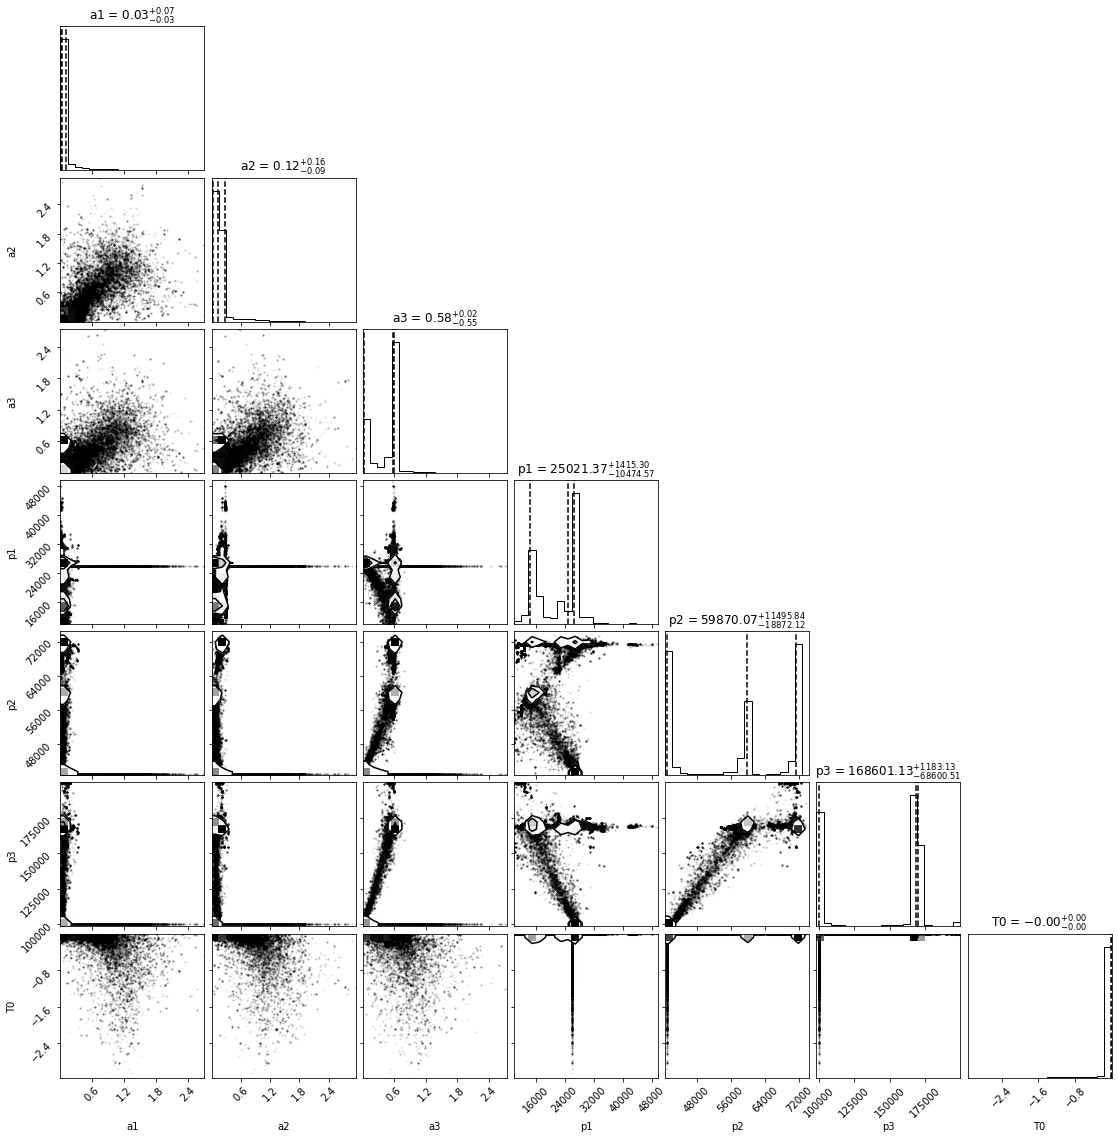

In [104]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])